In [1]:
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm,wandb

import IPython.display as disp
from timm.models import safe_model_name, set_fast_norm
from timm.models.layers import create_classifier, SelectAdaptivePool2d

In [2]:
%env WANDB_SILENT=true
warnings.filterwarnings('ignore')

env: WANDB_SILENT=true


In [3]:
VERSION  = "NB_EXP_011"
EXP_NAME = f"{VERSION}_convnext_tiny"

CSV_PATH     = Path('/data/train.csv')
DATA_PATH    = Path('/data/')
IMAGE_FOLDER = Path('/data/train/')
MODEL_FOLDER = Path(f'/runs/{VERSION}')

os.makedirs(MODEL_FOLDER, exist_ok=True)

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}


TIMM_MODEL  = "convnext_tiny_in22ft1k"

NFOLDS = 5
BS = 32
SZ = 256
RE = True

In [4]:
all_df = pd.read_csv(CSV_PATH)
all_df.head()

,seed_id,view,image,label
0,0,top,train/00000.png,broken
1,1,bottom,train/00001.png,pure
2,3,top,train/00003.png,broken
3,4,top,train/00004.png,pure
4,5,top,train/00005.png,discolored


In [5]:
folds = all_df.copy()
fold_splits = []

Fold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["label"])):
    fold_splits.append(val_index)
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

In [6]:
@Transform
def hflip(x: TensorTypes): return x.flip(3)

@Transform
def vflip(x: TensorTypes): return x.flip(2)

In [7]:
def get_dls(fold:int, size:int, bs:int, re:bool = False):
    
    item_tfms = [ToTensor, Resize(size, method=ResizeMethod.Squish)]
    aug_tfm = aug_transforms(flip_vert=True, 
                             max_rotate=360, 
                             max_zoom=1.3, 
                             max_lighting=0.1, 
                             p_lighting=0.5, 
                             pad_mode=PadMode.Zeros)
    batch_tfms = [IntToFloatTensor, *aug_tfm, Normalize.from_stats(*imagenet_stats)]
    if re: batch_tfms.append(RandomErasing(p=0.75))
    
    dblock = DataBlock(
        blocks     = (ImageBlock, CategoryBlock(vocab=LABELS)),
        splitter   = IndexSplitter(fold_splits[fold]),
        get_x      = ColReader('image', pref=DATA_PATH),
        get_y      = [ColReader('label')],
        item_tfms  = item_tfms,
        batch_tfms = batch_tfms )
    
    dls = dblock.dataloaders(folds, bs=bs)
    return dls

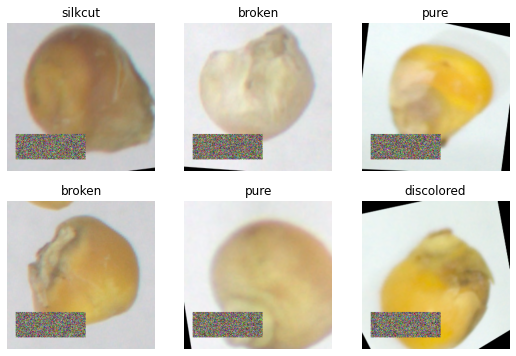

In [8]:
dls = get_dls(0, size=SZ, bs=BS, re=RE)
dls.show_batch(max_n=6)

In [9]:
from timm.models.helpers import group_modules, group_parameters

def timm_get_module_names(m):
    modules_names = group_modules(m, m.group_matcher(coarse=True))
    return L(modules_names.values())[:-1] #cut timm head

def timm_get_param_names(m):
    param_names = group_parameters(m, m.group_matcher(coarse=True))
    return L(param_names.values())[:-1] #cut timm head

def timm_body_params(timm_model, cut=-1):
    param_names = timm_get_param_names(timm_model)
    return L(param_names[:cut].concat(), param_names[cut:].concat())

def timm_split(m, cut=-1):
    "Splitter function for timm models"
    timm_model, head = m[0].model, m[1]
    body_groups = [g.map(timm_model.get_parameter) for g in timm_body_params(timm_model, cut)]
    return body_groups + [params(head)]

In [ ]:
# set_seed(42);set_fast_norm()

# with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
                           
#     dls = get_dls(0, size=SZ, bs=BS, re=RE)
    
#     learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
#                            loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
#                            splitter=partial(timm_split, cut=-3)).to_fp16()
    
#     print(learn.lr_find(suggest_funcs=(valley, slide)))

In [10]:
n_epo = 15; base_lr = 2e-03; 
SUFFIX = f"{SZ}_bs{BS}_epo{n_epo}_augsV2_mixup_ft"
print(EXP_NAME+'_'+SUFFIX)
set_seed(42); set_fast_norm()

NB_EXP_011_convnext_tiny_256_bs32_epo15_augsV2_mixup_ft


In [11]:
for fold_idx in range(NFOLDS):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        
        with wandb.init(project='pog3_corn',
                        group=EXP_NAME, save_code=True,
                        name=f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'):
        
            dls = get_dls(fold_idx, size=SZ, bs=BS, re=RE)

            learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
                                   loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                                   splitter=partial(timm_split, cut=-3)).to_fp16()

            cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater),
                   WandbCallback(log_preds=None),
                   MixUp(alpha=0.4)] # fastai default MixUp
            
            learn.fine_tune(n_epo, base_lr, cbs=cbs)

            learn = learn.load("model")
            learn = learn.to_fp32()

            dirpath = MODEL_FOLDER/f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'
            learn.save(dirpath, with_opt=False)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.295341,0.847198,0.675393,00:33


Better model found at epoch 0 with accuracy value: 0.6753926873207092.


epoch,train_loss,valid_loss,accuracy,time
0,1.007191,0.707053,0.725654,00:44
1,0.942451,0.659478,0.736475,00:44
2,0.873251,0.622697,0.749738,00:44
3,0.892271,0.618620,0.757766,00:44
4,0.833738,0.594184,0.768935,00:44
5,0.834823,0.603856,0.746597,00:44
6,0.794599,0.550972,0.781152,00:44
7,0.779040,0.523859,0.788133,00:44
8,0.751854,0.525142,0.788133,00:44
9,0.745768,0.505966,0.797557,00:44


Better model found at epoch 0 with accuracy value: 0.7256544232368469.
Better model found at epoch 1 with accuracy value: 0.7364746928215027.
Better model found at epoch 2 with accuracy value: 0.7497382164001465.
Better model found at epoch 3 with accuracy value: 0.7577661275863647.
Better model found at epoch 4 with accuracy value: 0.7689354419708252.
Better model found at epoch 6 with accuracy value: 0.7811518311500549.
Better model found at epoch 7 with accuracy value: 0.7881326079368591.
Better model found at epoch 9 with accuracy value: 0.7975566983222961.
Better model found at epoch 10 with accuracy value: 0.8055846691131592.
Better model found at epoch 12 with accuracy value: 0.8101221919059753.
CPU: 822/87/3709 MB | GPU: 758/2340/6897 MB | Time 0:11:59.643 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.286348,0.831148,0.660035,00:33


Better model found at epoch 0 with accuracy value: 0.6600348949432373.


epoch,train_loss,valid_loss,accuracy,time
0,1.020079,0.712863,0.712391,00:44
1,0.926416,0.671690,0.745201,00:44
2,0.897942,0.624079,0.750087,00:44
3,0.869695,0.612064,0.750785,00:44
4,0.848319,0.588182,0.771030,00:44
5,0.818903,0.557709,0.784991,00:44
6,0.821624,0.527195,0.790925,00:44
7,0.789049,0.536554,0.790925,00:44
8,0.781278,0.530539,0.796510,00:44
9,0.758596,0.529973,0.788831,00:44


Better model found at epoch 0 with accuracy value: 0.7123908996582031.
Better model found at epoch 1 with accuracy value: 0.7452006936073303.
Better model found at epoch 2 with accuracy value: 0.7500872611999512.
Better model found at epoch 3 with accuracy value: 0.7507853507995605.
Better model found at epoch 4 with accuracy value: 0.7710296511650085.
Better model found at epoch 5 with accuracy value: 0.7849912643432617.
Better model found at epoch 6 with accuracy value: 0.7909249663352966.
Better model found at epoch 8 with accuracy value: 0.7965096235275269.
Better model found at epoch 10 with accuracy value: 0.8076788783073425.
Better model found at epoch 11 with accuracy value: 0.8195462226867676.
CPU: 95/95/3805 MB | GPU: 172/2726/7069 MB | Time 0:12:02.035 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.290731,0.871349,0.657472,00:34


Better model found at epoch 0 with accuracy value: 0.6574720740318298.


epoch,train_loss,valid_loss,accuracy,time
0,1.005789,0.677709,0.731145,00:44
1,0.929290,0.702488,0.719623,00:44
2,0.876853,0.635339,0.733589,00:44
3,0.857847,0.695344,0.714385,00:44
4,0.832593,0.572062,0.769204,00:44
5,0.809599,0.652759,0.744763,00:44
6,0.815617,0.626007,0.747905,00:44
7,0.789677,0.555015,0.790852,00:44
8,0.787494,0.521931,0.791899,00:44
9,0.744269,0.565897,0.783869,00:44


Better model found at epoch 0 with accuracy value: 0.7311452627182007.
Better model found at epoch 2 with accuracy value: 0.7335894107818604.
Better model found at epoch 4 with accuracy value: 0.7692039012908936.
Better model found at epoch 7 with accuracy value: 0.7908519506454468.
Better model found at epoch 8 with accuracy value: 0.7918994426727295.
Better model found at epoch 10 with accuracy value: 0.8002793192863464.
Better model found at epoch 11 with accuracy value: 0.8062151074409485.
Better model found at epoch 12 with accuracy value: 0.8135474920272827.
CPU: 62/83/3867 MB | GPU: 90/2616/7159 MB | Time 0:12:03.680 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.301969,0.850785,0.665154,00:34


Better model found at epoch 0 with accuracy value: 0.6651536226272583.


epoch,train_loss,valid_loss,accuracy,time
0,0.997124,0.654676,0.736732,00:44
1,0.936834,0.614009,0.762221,00:44
2,0.883367,0.613750,0.765712,00:44
3,0.879679,0.583552,0.766760,00:44
4,0.836940,0.570561,0.779330,00:44
5,0.832576,0.538036,0.783520,00:44
6,0.830919,0.522650,0.800978,00:44
7,0.797463,0.493617,0.813198,00:44
8,0.767144,0.498442,0.801676,00:44
9,0.756980,0.473410,0.809008,00:44


Better model found at epoch 0 with accuracy value: 0.7367318272590637.
Better model found at epoch 1 with accuracy value: 0.7622206807136536.
Better model found at epoch 2 with accuracy value: 0.7657122611999512.
Better model found at epoch 3 with accuracy value: 0.7667597532272339.
Better model found at epoch 4 with accuracy value: 0.7793295979499817.
Better model found at epoch 5 with accuracy value: 0.7835195660591125.
Better model found at epoch 6 with accuracy value: 0.8009776473045349.
Better model found at epoch 7 with accuracy value: 0.8131983280181885.
Better model found at epoch 11 with accuracy value: 0.8177374005317688.
Better model found at epoch 12 with accuracy value: 0.8215782046318054.
CPU: 3/73/3870 MB | GPU: 110/2510/7269 MB | Time 0:12:03.561 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.262183,0.866301,0.665503,00:34


Better model found at epoch 0 with accuracy value: 0.6655027866363525.


epoch,train_loss,valid_loss,accuracy,time
0,1.018632,0.656768,0.745810,00:44
1,0.922537,0.672507,0.745810,00:44
2,0.891480,0.603265,0.756285,00:44
3,0.863204,0.559537,0.781774,00:44
4,0.874024,0.543902,0.781425,00:44
5,0.838713,0.569635,0.787709,00:44
6,0.826454,0.514029,0.795042,00:44
7,0.805841,0.509709,0.806215,00:44
8,0.791017,0.495026,0.802374,00:44
9,0.754558,0.492723,0.806913,00:44


Better model found at epoch 0 with accuracy value: 0.7458100318908691.
Better model found at epoch 2 with accuracy value: 0.7562848925590515.
Better model found at epoch 3 with accuracy value: 0.7817737460136414.
Better model found at epoch 5 with accuracy value: 0.7877094745635986.
Better model found at epoch 6 with accuracy value: 0.7950419187545776.
Better model found at epoch 7 with accuracy value: 0.8062151074409485.
Better model found at epoch 9 with accuracy value: 0.806913435459137.
Better model found at epoch 10 with accuracy value: 0.8163408041000366.
CPU: 1/54/3871 MB | GPU: -14/2484/7255 MB | Time 0:12:03.032 | (Consumed/Peaked/Used Total)


In [12]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        dls = get_dls(fold_index, size=SZ, bs=BS, re=RE)

        learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=False,
                               loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                               splitter=partial(timm_split, cut=-3),model_dir=MODEL_FOLDER).to_fp16()
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"Load from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        tst_dl = dls.valid.new()
        with tst_dl.dataset.set_split_idx(1), learn.no_mbar():
            preds0, targs = learn.get_preds(dl=tst_dl)
        
        tst_dl_1 = dls.valid.new()
        tst_dl_1.after_batch.add(hflip)
        with tst_dl_1.dataset.set_split_idx(1), learn.no_mbar():
            preds1, _ = learn.get_preds(dl=tst_dl_1)
        
        tst_dl_2 = dls.valid.new()
        tst_dl_2.after_batch.add(vflip)
        with tst_dl_2.dataset.set_split_idx(1), learn.no_mbar():
            preds2, _ = learn.get_preds(dl=tst_dl_2)
        
        preds = (preds0+preds1+preds2)/3
        acc = accuracy(preds, targs).item()
        
        folds_val_score.append(acc)

disp.clear_output()    
print("============ Run summary (hflip+vflip TTA) ============")
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))

============ Run summary (hflip+vflip TTA) ============
folds score:  [0.80838, 0.8185, 0.81669, 0.81948, 0.81844]
Avg: 0.81630
Std: 0.00406


**Increase Mixup More ??**

In [21]:
VERSION  = "NB_EXP_011_v2"
EXP_NAME = f"{VERSION}_convnext_tiny"
MODEL_FOLDER = Path(f'/runs/{VERSION}'); MODEL_FOLDER.mkdir(exist_ok=True)


TIMM_MODEL  = "convnext_tiny_in22ft1k"

NFOLDS = 5
BS = 32
SZ = 256
RE = True

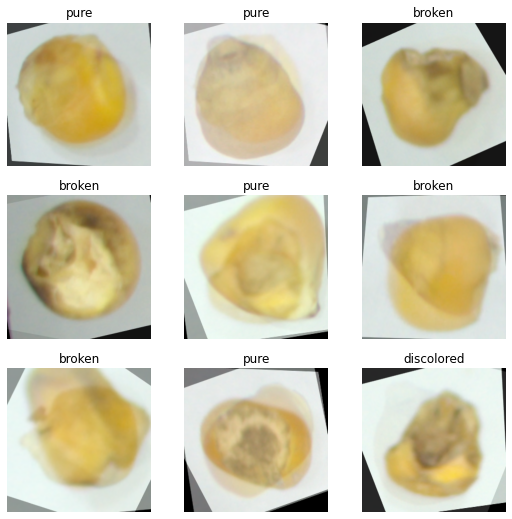

In [24]:
dls = get_dls(0, SZ, BS, RE)
mixup = MixUp(1.)

with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup) as learn:
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_train')
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(mixup.x,mixup.y), ctxs=axs.flatten())

In [25]:
n_epo = 15; base_lr = 2e-03; 
SUFFIX = f"{SZ}_bs{BS}_epo{n_epo}_augsV2_mixup_ft"
print(EXP_NAME + '_' + SUFFIX)
set_seed(42); set_fast_norm()

NB_EXP_011_v2_convnext_tiny_256_bs32_epo15_augsV2_mixup_ft


In [26]:
for fold_idx in range(NFOLDS):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        
        with wandb.init(project='pog3_corn',
                        group=EXP_NAME, save_code=True,
                        name=f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'):
        
            dls = get_dls(fold_idx, size=SZ, bs=BS, re=RE)

            learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
                    loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                    splitter=partial(timm_split, cut=-3)).to_fp16()

            cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater),
                   WandbCallback(log_preds=None), MixUp(alpha=1.0)]
            
            learn.fine_tune(n_epo, base_lr, cbs=cbs)

            learn = learn.load("model")
            learn = learn.to_fp32()

            dirpath = MODEL_FOLDER/f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'
            learn.save(dirpath, with_opt=False)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.335958,0.887175,0.643630,00:34


Better model found at epoch 0 with accuracy value: 0.6436300277709961.


epoch,train_loss,valid_loss,accuracy,time
0,1.091782,0.701833,0.718674,00:44
1,1.034220,0.679175,0.741710,00:44
2,0.978254,0.715302,0.717277,00:44
3,0.970681,0.694972,0.707155,00:44
4,0.923229,0.583147,0.772426,00:45
5,0.912327,0.582437,0.766841,00:44
6,0.905753,0.597938,0.763002,00:45
7,0.877687,0.540581,0.785689,00:45
8,0.868135,0.539160,0.787435,00:44
9,0.845611,0.525075,0.787435,00:44


Better model found at epoch 0 with accuracy value: 0.7186736464500427.
Better model found at epoch 1 with accuracy value: 0.7417103052139282.
Better model found at epoch 4 with accuracy value: 0.7724258303642273.
Better model found at epoch 7 with accuracy value: 0.7856893539428711.
Better model found at epoch 8 with accuracy value: 0.7874345779418945.
Better model found at epoch 10 with accuracy value: 0.7972076535224915.
Better model found at epoch 12 with accuracy value: 0.8020942211151123.
CPU: 47/84/4065 MB | GPU: 442/2394/6948 MB | Time 0:12:04.967 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.357016,0.901785,0.634206,00:34


Better model found at epoch 0 with accuracy value: 0.6342059373855591.


epoch,train_loss,valid_loss,accuracy,time
0,1.077923,0.719218,0.716579,00:44
1,0.994981,0.657274,0.749040,00:44
2,0.978590,0.667488,0.730192,00:44
3,0.967464,0.652184,0.735777,00:45
4,0.921180,0.641778,0.741012,00:44
5,0.911821,0.578780,0.776614,00:45
6,0.913481,0.576012,0.774520,00:45
7,0.892556,0.533128,0.789180,00:45
8,0.872644,0.532088,0.793019,00:45
9,0.865331,0.548379,0.787086,00:45


Better model found at epoch 0 with accuracy value: 0.7165793776512146.
Better model found at epoch 1 with accuracy value: 0.7490401268005371.
Better model found at epoch 5 with accuracy value: 0.7766143083572388.
Better model found at epoch 7 with accuracy value: 0.7891797423362732.
Better model found at epoch 8 with accuracy value: 0.79301917552948.
Better model found at epoch 10 with accuracy value: 0.8027923107147217.
Better model found at epoch 11 with accuracy value: 0.8108202219009399.
Better model found at epoch 13 with accuracy value: 0.8115183115005493.
Better model found at epoch 14 with accuracy value: 0.8150086998939514.
CPU: 42/89/4107 MB | GPU: 194/2696/7142 MB | Time 0:12:07.612 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.340930,0.959710,0.612081,00:34


Better model found at epoch 0 with accuracy value: 0.612080991268158.


epoch,train_loss,valid_loss,accuracy,time
0,1.087534,0.712565,0.709497,00:44
1,1.003542,0.729659,0.710894,00:45
2,0.975724,0.709646,0.715433,00:45
3,0.953670,0.616687,0.756285,00:45
4,0.915722,0.621807,0.763268,00:45
5,0.909351,0.649935,0.756285,00:45
6,0.897867,0.581516,0.774791,00:45
7,0.882282,0.583713,0.775489,00:45
8,0.866599,0.542441,0.792947,00:45
9,0.860942,0.525566,0.796788,00:45


Better model found at epoch 0 with accuracy value: 0.7094972133636475.
Better model found at epoch 1 with accuracy value: 0.7108938694000244.
Better model found at epoch 2 with accuracy value: 0.7154329419136047.
Better model found at epoch 3 with accuracy value: 0.7562848925590515.
Better model found at epoch 4 with accuracy value: 0.7632681727409363.
Better model found at epoch 6 with accuracy value: 0.7747905254364014.
Better model found at epoch 7 with accuracy value: 0.7754888534545898.
Better model found at epoch 8 with accuracy value: 0.7929469347000122.
Better model found at epoch 9 with accuracy value: 0.7967877388000488.
Better model found at epoch 10 with accuracy value: 0.8076117038726807.
Better model found at epoch 13 with accuracy value: 0.8121508359909058.
CPU: -116/89/3991 MB | GPU: 56/2644/7198 MB | Time 0:12:09.469 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.349391,0.900294,0.632682,00:34


Better model found at epoch 0 with accuracy value: 0.6326815485954285.


epoch,train_loss,valid_loss,accuracy,time
0,1.068086,0.681775,0.725908,00:44
1,1.028419,0.643210,0.750349,00:45
2,0.967864,0.655638,0.740223,00:45
3,0.974675,0.581709,0.780028,00:44
4,0.919446,0.569555,0.772346,00:45
5,0.935799,0.601983,0.750349,00:44
6,0.922313,0.516299,0.803073,00:45
7,0.898488,0.537133,0.791899,00:44
8,0.868759,0.503608,0.805517,00:44
9,0.871290,0.488677,0.806913,00:45


Better model found at epoch 0 with accuracy value: 0.7259078025817871.
Better model found at epoch 1 with accuracy value: 0.7503491640090942.
Better model found at epoch 3 with accuracy value: 0.7800279259681702.
Better model found at epoch 6 with accuracy value: 0.8030726313591003.
Better model found at epoch 8 with accuracy value: 0.80551677942276.
Better model found at epoch 9 with accuracy value: 0.806913435459137.
Better model found at epoch 10 with accuracy value: 0.8114525079727173.
Better model found at epoch 11 with accuracy value: 0.8149441480636597.
Better model found at epoch 13 with accuracy value: 0.8156424760818481.
Better model found at epoch 14 with accuracy value: 0.8212290406227112.
CPU: 99/86/4090 MB | GPU: 118/2530/7316 MB | Time 0:12:07.030 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.362791,0.880646,0.640014,00:34


Better model found at epoch 0 with accuracy value: 0.6400139927864075.


epoch,train_loss,valid_loss,accuracy,time
0,1.078122,0.734583,0.715433,00:45
1,1.002207,0.656144,0.738128,00:45
2,0.979396,0.671153,0.743017,00:45
3,0.930467,0.619164,0.757332,00:45
4,0.938883,0.551655,0.783170,00:45
5,0.924371,0.562297,0.797137,00:45
6,0.908233,0.538850,0.784567,00:45
7,0.903977,0.551111,0.788408,00:45
8,0.879543,0.533096,0.792947,00:45
9,0.867984,0.499169,0.808659,00:44


Better model found at epoch 0 with accuracy value: 0.7154329419136047.
Better model found at epoch 1 with accuracy value: 0.7381284832954407.
Better model found at epoch 2 with accuracy value: 0.74301677942276.
Better model found at epoch 3 with accuracy value: 0.7573323845863342.
Better model found at epoch 4 with accuracy value: 0.7831704020500183.
Better model found at epoch 5 with accuracy value: 0.7971368432044983.
Better model found at epoch 9 with accuracy value: 0.8086591958999634.
Better model found at epoch 11 with accuracy value: 0.8097066879272461.
Better model found at epoch 12 with accuracy value: 0.8149441480636597.
Better model found at epoch 14 with accuracy value: 0.8173882961273193.
CPU: -102/87/3988 MB | GPU: 70/2452/7386 MB | Time 0:12:09.241 | (Consumed/Peaked/Used Total)


In [27]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        dls = get_dls(fold_index, size=SZ, bs=BS, re=RE)

        learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=False,
                               loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                               splitter=partial(timm_split, cut=-3),model_dir=MODEL_FOLDER).to_fp16()
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"Load from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        tst_dl = dls.valid.new()
        with tst_dl.dataset.set_split_idx(1), learn.no_mbar():
            preds0, targs = learn.get_preds(dl=tst_dl)
        
        tst_dl_1 = dls.valid.new()
        tst_dl_1.after_batch.add(hflip)
        with tst_dl_1.dataset.set_split_idx(1), learn.no_mbar():
            preds1, _ = learn.get_preds(dl=tst_dl_1)
        
        tst_dl_2 = dls.valid.new()
        tst_dl_2.after_batch.add(vflip)
        with tst_dl_2.dataset.set_split_idx(1), learn.no_mbar():
            preds2, _ = learn.get_preds(dl=tst_dl_2)
        
        preds = (preds0+preds1+preds2)/3
        acc = accuracy(preds, targs).item()
        
        folds_val_score.append(acc)

disp.clear_output()    
print("============ Run summary (hflip+vflip TTA) ============")
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))

============ Run summary (hflip+vflip TTA) ============
folds score:  [0.80244, 0.81571, 0.81809, 0.81913, 0.82018]
Avg: 0.81511
Std: 0.00651


**Increase Epochs ?**

In [28]:
VERSION  = "NB_EXP_011_v3"
EXP_NAME = f"{VERSION}_convnext_tiny"
MODEL_FOLDER = Path(f'/runs/{VERSION}'); MODEL_FOLDER.mkdir(exist_ok=True)


TIMM_MODEL  = "convnext_tiny_in22ft1k"

NFOLDS = 5
BS = 32
SZ = 256
RE = True

n_epo = 20; base_lr = 2e-03; 
SUFFIX = f"{SZ}_bs{BS}_epo{n_epo}_augsV2_mixup_ft"
print(EXP_NAME + '_' + SUFFIX)
set_seed(42); set_fast_norm()

NB_EXP_011_v3_convnext_tiny_256_bs32_epo20_augsV2_mixup_ft


In [29]:
for fold_idx in range(NFOLDS):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        
        with wandb.init(project='pog3_corn',
                        group=EXP_NAME, save_code=True,
                        name=f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'):
        
            dls = get_dls(fold_idx, size=SZ, bs=BS, re=RE)

            learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=True,
                    loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                    splitter=partial(timm_split, cut=-3)).to_fp16()

            cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater),
                   WandbCallback(log_preds=None), MixUp(alpha=1.0)]
            
            learn.fine_tune(n_epo, base_lr, cbs=cbs)

            learn = learn.load("model")
            learn = learn.to_fp32()

            dirpath = MODEL_FOLDER/f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'
            learn.save(dirpath, with_opt=False)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.335958,0.887175,0.643630,00:34


Better model found at epoch 0 with accuracy value: 0.6436300277709961.


epoch,train_loss,valid_loss,accuracy,time
0,1.086753,0.693110,0.722164,00:45
1,1.033202,0.666929,0.738220,00:45
2,0.979441,0.716174,0.711344,00:45
3,0.965962,0.646077,0.749040,00:45
4,0.926638,0.636080,0.749040,00:45
5,0.921510,0.627887,0.747644,00:45
6,0.913286,0.594622,0.764049,00:45
7,0.890196,0.549603,0.785340,00:45
8,0.891140,0.551952,0.782897,00:45
9,0.873104,0.524334,0.789878,00:45


Better model found at epoch 0 with accuracy value: 0.7221640348434448.
Better model found at epoch 1 with accuracy value: 0.7382199168205261.
Better model found at epoch 3 with accuracy value: 0.7490401268005371.
Better model found at epoch 6 with accuracy value: 0.7640488743782043.
Better model found at epoch 7 with accuracy value: 0.7853403091430664.
Better model found at epoch 9 with accuracy value: 0.7898778319358826.
Better model found at epoch 14 with accuracy value: 0.79301917552948.
Better model found at epoch 15 with accuracy value: 0.7986038327217102.
Better model found at epoch 16 with accuracy value: 0.8076788783073425.
CPU: 1/135/4122 MB | GPU: 364/2312/7094 MB | Time 0:16:05.604 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.357016,0.901785,0.634206,00:34


Better model found at epoch 0 with accuracy value: 0.6342059373855591.


epoch,train_loss,valid_loss,accuracy,time
0,1.084929,0.691738,0.728447,00:45
1,1.000292,0.681382,0.739965,00:45
2,0.986189,0.638214,0.744154,00:45
3,0.966339,0.611409,0.761257,00:45
4,0.940203,0.591166,0.764049,00:45
5,0.925359,0.601704,0.767539,00:45
6,0.923334,0.569046,0.775567,00:45
7,0.902422,0.559154,0.773473,00:45
8,0.896065,0.558331,0.774520,00:45
9,0.885334,0.600764,0.758464,00:45


Better model found at epoch 0 with accuracy value: 0.7284467816352844.
Better model found at epoch 1 with accuracy value: 0.7399650812149048.
Better model found at epoch 2 with accuracy value: 0.7441535592079163.
Better model found at epoch 3 with accuracy value: 0.7612565159797668.
Better model found at epoch 4 with accuracy value: 0.7640488743782043.
Better model found at epoch 5 with accuracy value: 0.7675392627716064.
Better model found at epoch 6 with accuracy value: 0.7755671739578247.
Better model found at epoch 10 with accuracy value: 0.7895287871360779.
Better model found at epoch 11 with accuracy value: 0.8031413555145264.
Better model found at epoch 13 with accuracy value: 0.8129144906997681.
Better model found at epoch 17 with accuracy value: 0.8167539238929749.
CPU: 0/141/4123 MB | GPU: 180/2552/7274 MB | Time 0:16:05.305 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.340930,0.959710,0.612081,00:34


Better model found at epoch 0 with accuracy value: 0.612080991268158.


epoch,train_loss,valid_loss,accuracy,time
0,1.082047,0.728325,0.707751,00:45
1,0.998018,0.706264,0.717877,00:45
2,0.972068,0.640107,0.740922,00:45
3,0.948920,0.628320,0.735684,00:45
4,0.921610,0.645350,0.743017,00:45
5,0.920369,0.705576,0.739525,00:45
6,0.909041,0.654108,0.753841,00:45
7,0.898853,0.607442,0.766061,00:45
8,0.886769,0.542401,0.783170,00:45
9,0.881853,0.590254,0.758031,00:45


Better model found at epoch 0 with accuracy value: 0.7077513933181763.
Better model found at epoch 1 with accuracy value: 0.7178770899772644.
Better model found at epoch 2 with accuracy value: 0.7409217953681946.
Better model found at epoch 4 with accuracy value: 0.74301677942276.
Better model found at epoch 6 with accuracy value: 0.7538408041000366.
Better model found at epoch 7 with accuracy value: 0.7660614252090454.
Better model found at epoch 8 with accuracy value: 0.7831704020500183.
Better model found at epoch 10 with accuracy value: 0.8009776473045349.
Better model found at epoch 12 with accuracy value: 0.8020251393318176.
Better model found at epoch 15 with accuracy value: 0.8051676154136658.
CPU: -61/141/4061 MB | GPU: -21/2564/7252 MB | Time 0:16:10.128 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.349391,0.900294,0.632682,00:34


Better model found at epoch 0 with accuracy value: 0.6326815485954285.


epoch,train_loss,valid_loss,accuracy,time
0,1.065884,0.704687,0.717528,00:45
1,1.020606,0.651403,0.739874,00:45
2,0.974691,0.641671,0.736383,00:45
3,0.966746,0.595554,0.773045,00:45
4,0.918352,0.570398,0.785615,00:45
5,0.942846,0.600562,0.752793,00:45
6,0.931940,0.540308,0.794344,00:45
7,0.913686,0.576554,0.769553,00:45
8,0.890597,0.527116,0.794344,00:45
9,0.893593,0.492758,0.804469,00:45


Better model found at epoch 0 with accuracy value: 0.7175279259681702.
Better model found at epoch 1 with accuracy value: 0.7398743033409119.
Better model found at epoch 3 with accuracy value: 0.7730447053909302.
Better model found at epoch 4 with accuracy value: 0.785614550113678.
Better model found at epoch 6 with accuracy value: 0.7943435907363892.
Better model found at epoch 9 with accuracy value: 0.8044692873954773.
Better model found at epoch 13 with accuracy value: 0.8121508359909058.
Better model found at epoch 16 with accuracy value: 0.8198323845863342.
CPU: 37/137/4098 MB | GPU: 97/2496/7350 MB | Time 0:16:05.545 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)



epoch,train_loss,valid_loss,accuracy,time
0,1.362791,0.880646,0.640014,00:34


Better model found at epoch 0 with accuracy value: 0.6400139927864075.


epoch,train_loss,valid_loss,accuracy,time
0,1.076566,0.716369,0.717877,00:45
1,1.005075,0.664964,0.740922,00:45
2,0.976427,0.660876,0.752444,00:45
3,0.934429,0.602086,0.766061,00:45
4,0.941270,0.557833,0.779330,00:45
5,0.930793,0.582939,0.780028,00:45
6,0.920377,0.544414,0.778631,00:45
7,0.921463,0.606310,0.774092,00:45
8,0.904651,0.575022,0.769553,00:45
9,0.890590,0.517380,0.800978,00:45


Better model found at epoch 0 with accuracy value: 0.7178770899772644.
Better model found at epoch 1 with accuracy value: 0.7409217953681946.
Better model found at epoch 2 with accuracy value: 0.7524441480636597.
Better model found at epoch 3 with accuracy value: 0.7660614252090454.
Better model found at epoch 4 with accuracy value: 0.7793295979499817.
Better model found at epoch 5 with accuracy value: 0.7800279259681702.
Better model found at epoch 9 with accuracy value: 0.8009776473045349.
Better model found at epoch 11 with accuracy value: 0.8030726313591003.
Better model found at epoch 12 with accuracy value: 0.8034217953681946.
Better model found at epoch 13 with accuracy value: 0.8121508359909058.
Better model found at epoch 15 with accuracy value: 0.8135474920272827.
Better model found at epoch 16 with accuracy value: 0.813896656036377.
Better model found at epoch 18 with accuracy value: 0.8159916400909424.
CPU: 0/137/4099 MB | GPU: 74/2426/7424 MB | Time 0:16:07.901 | (Consumed

In [30]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        dls = get_dls(fold_index, size=SZ, bs=BS, re=RE)

        learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=False,
                               loss_func=CrossEntropyLossFlat(), metrics=[accuracy], 
                               splitter=partial(timm_split, cut=-3),model_dir=MODEL_FOLDER).to_fp16()
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"Load from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        tst_dl = dls.valid.new()
        with tst_dl.dataset.set_split_idx(1), learn.no_mbar():
            preds0, targs = learn.get_preds(dl=tst_dl)
        
        tst_dl_1 = dls.valid.new()
        tst_dl_1.after_batch.add(hflip)
        with tst_dl_1.dataset.set_split_idx(1), learn.no_mbar():
            preds1, _ = learn.get_preds(dl=tst_dl_1)
        
        tst_dl_2 = dls.valid.new()
        tst_dl_2.after_batch.add(vflip)
        with tst_dl_2.dataset.set_split_idx(1), learn.no_mbar():
            preds2, _ = learn.get_preds(dl=tst_dl_2)
        
        preds = (preds0+preds1+preds2)/3
        acc = accuracy(preds, targs).item()
        
        folds_val_score.append(acc)

disp.clear_output()    
print("============ Run summary (hflip+vflip TTA) ============")
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))

============ Run summary (hflip+vflip TTA) ============
folds score:  [0.80803, 0.81606, 0.80517, 0.82612, 0.81459]
Avg: 0.81399
Std: 0.00728
